In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-estimation/datasets_33080_43333_car data.csv


In [2]:
df=pd.read_csv('../input/car-price-estimation/datasets_33080_43333_car data.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [4]:
print('Transmission types :',df['Transmission'].unique())
print('Fuel type: ',df['Fuel_Type'].unique())
print('Seller Type: ',df['Seller_Type'].unique())

Transmission types : ['Manual' 'Automatic']
Fuel type:  ['Petrol' 'Diesel' 'CNG']
Seller Type:  ['Dealer' 'Individual']


In [5]:
#missing values
df.isnull().any()

Car_Name         False
Year             False
Selling_Price    False
Present_Price    False
Kms_Driven       False
Fuel_Type        False
Seller_Type      False
Transmission     False
Owner            False
dtype: bool

In [6]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [7]:
df['Current_year']=2020
df['Age_of_Car']=df['Current_year']-df['Year']

In [8]:
df.drop(['Year','Current_year'],axis=1,inplace=True)
df.drop(['Car_Name'],axis=1,inplace=True)

In [9]:
df=pd.get_dummies(df,drop_first=True)

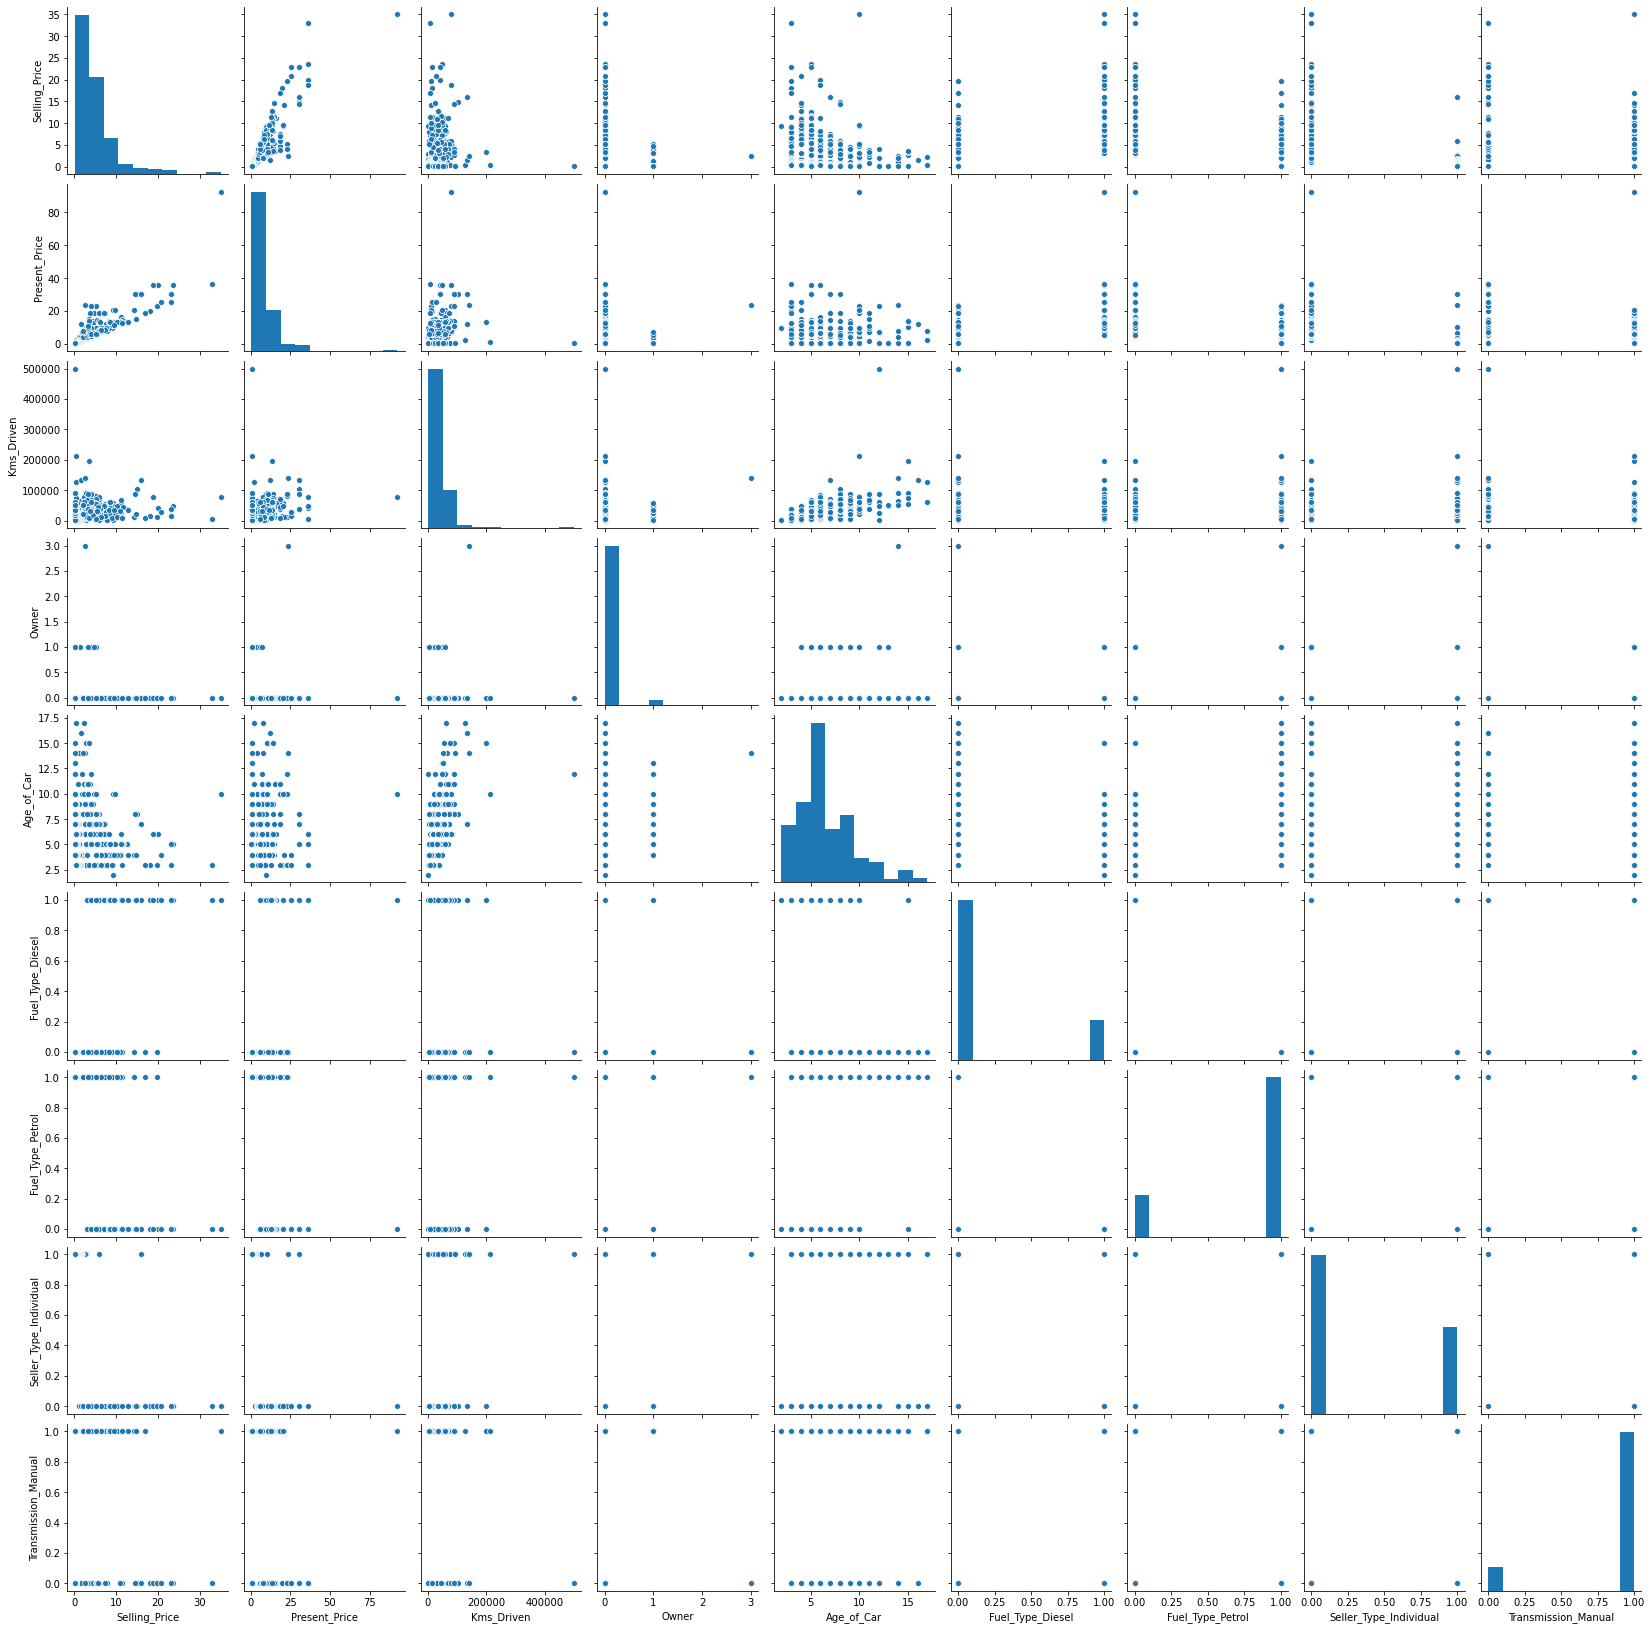

In [10]:
#correlation
correlation=df.corr
sns.pairplot(df)

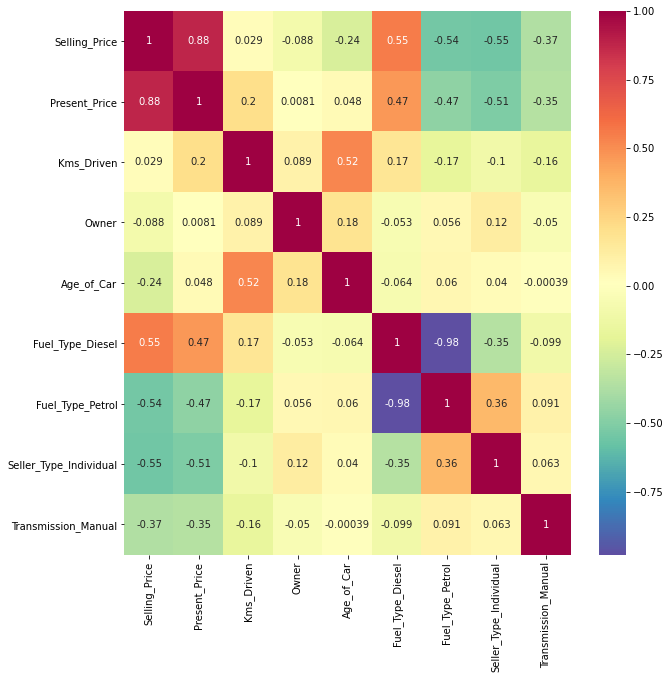

In [11]:
corr_mat=df.corr()
top_corr=corr_mat.index
plt.figure(figsize=(10,10))
sns.heatmap(df[top_corr].corr(),annot=True,cmap='Spectral_r')

In [12]:
df.columns

Index(['Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner', 'Age_of_Car',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Seller_Type_Individual',
       'Transmission_Manual'],
      dtype='object')

In [13]:
X=df.iloc[:,1:]
Y=df['Selling_Price']

In [14]:
from sklearn.ensemble import ExtraTreesRegressor
et=ExtraTreesRegressor()
et.fit(X,Y)

ExtraTreesRegressor()

In [15]:
print(et.feature_importances_)

[0.38763146 0.0415462  0.00041432 0.07641709 0.21791917 0.01561446
 0.12801518 0.13244213]


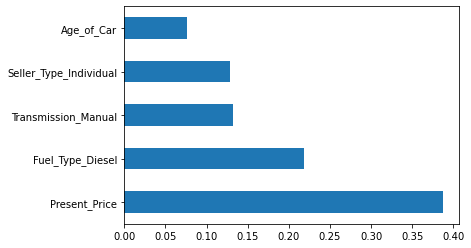

In [16]:
imp_fea=pd.Series(et.feature_importances_,index=X.columns)
imp_fea.nlargest(5).plot(kind='barh')

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [18]:
from xgboost import XGBRegressor

In [19]:
xgb=XGBRegressor()

In [20]:
n_estimators=[int(x) for x in np.linspace(start=100,stop=1500,num=12)]
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(5,30,num=6)]
min_sample_split=[2,4,6,10,100]
min_sample_leaf=[1,2,5,10]

In [21]:
from sklearn.model_selection import RandomizedSearchCV
random_grid={'n_estimators':n_estimators,
             'max_features':max_features,
             'max_depth':max_depth,
             'min_sample_split':min_sample_split,
              'min_sample_leaf':min_sample_leaf}

In [22]:
random_grid_rf={'n_estimators':n_estimators,
             'max_features':max_features,
             'max_depth':max_depth}

In [23]:
print(random_grid)

{'n_estimators': [100, 227, 354, 481, 609, 736, 863, 990, 1118, 1245, 1372, 1500], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_sample_split': [2, 4, 6, 10, 100], 'min_sample_leaf': [1, 2, 5, 10]}


In [24]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()

In [25]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid_rf,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2,
                                random_state=42, n_jobs = 1)

In [26]:
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2,
                                random_state=42, n_jobs = 1)

In [27]:
rf_random.fit(X_train,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1245, max_features=sqrt, max_depth=25 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1245, max_features=sqrt, max_depth=25, total=   2.6s
[CV] n_estimators=1245, max_features=sqrt, max_depth=25 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  n_estimators=1245, max_features=sqrt, max_depth=25, total=   2.7s
[CV] n_estimators=1245, max_features=sqrt, max_depth=25 ..............
[CV]  n_estimators=1245, max_features=sqrt, max_depth=25, total=   2.4s
[CV] n_estimators=1245, max_features=sqrt, max_depth=25 ..............
[CV]  n_estimators=1245, max_features=sqrt, max_depth=25, total=   2.4s
[CV] n_estimators=1245, max_features=sqrt, max_depth=25 ..............
[CV]  n_estimators=1245, max_features=sqrt, max_depth=25, total=   2.3s
[CV] n_estimators=990, max_features=sqrt, max_depth=5 ................
[CV] . n_estimators=990, max_features=sqrt, max_depth=5, total=   2.1s
[CV] n_estimators=990, max_features=sqrt, max_depth=5 ................
[CV] . n_estimators=990, max_features=sqrt, max_depth=5, total=   1.8s
[CV] n_estimators=990, max_features=sqrt, max_depth=5 ................
[CV] . n_estimators=990, max_features=sqrt, max_depth=5, total=   1.8s
[CV] n_estimators=990, max_features=sqrt, max_depth=5 ................
[C

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [100, 227, 354, 481,
                                                         609, 736, 863, 990,
                                                         1118, 1245, 1372,
                                                         1500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [28]:
xgb_random.fit(X_train,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1118, min_sample_split=4, min_sample_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:33:24] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features, min_sample_leaf, min_sample_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  n_estimators=1118, min_sample_split=4, min_sample_leaf=5, max_features=sqrt, max_depth=10, total=   0.5s
[CV] n_estimators=1118, min_sample_split=4, min_sample_leaf=5, max_features=sqrt, max_depth=10 
[18:33:24] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features, min_sample_leaf, min_sample_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  n_estimators=1118, min_sample_split=4

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=1118, min_sample_split=4, min_sample_leaf=5, max_features=sqrt, max_depth=10, total=   0.1s
[CV] n_estimators=1118, min_sample_split=4, min_sample_leaf=5, max_features=sqrt, max_depth=10 
[18:33:24] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features, min_sample_leaf, min_sample_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  n_estimators=1118, min_sample_split=4, min_sample_leaf=5, max_features=sqrt, max_depth=10, total=   0.1s
[CV] n_estimators=1118, min_sample_split=4, min_sample_leaf=5, max_features=sqrt, max_depth=10 
[18:33:25] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features, min_sample_leaf, min_sample_split } might not be used.

  This may not be accurate due to some parameters are only used in language

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.7s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

In [29]:
pred_rf=rf_random.predict(X_test)

In [30]:
pred=xgb_random.predict(X_test)

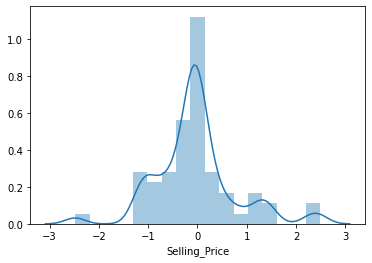

In [31]:
sns.distplot(Y_test-pred)

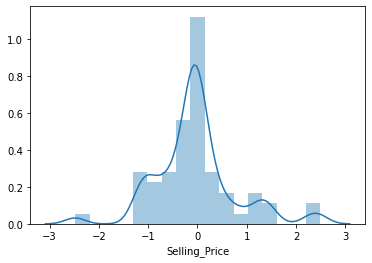

In [32]:
sns.distplot(Y_test-pred)